# 模型準確率評估


In [35]:
import sys
import time
from pathlib import Path

import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from PIL import Image
from torchvision import transforms
from tqdm import tqdm

# 加入專案根目錄到 import 路徑中
BASE_DIR = Path("..").resolve()
sys.path.append(str(BASE_DIR))

from src.model.model import CaptchaModel
from src.model.utils import CHARACTER_SET, decode_prediction

# 路徑設定
IMG_DIR = BASE_DIR / "data" / "captcha_generate" / "images"
LABELS_PATH = BASE_DIR / "data" / "captcha_generate" / "labels.csv"
MODEL_PATH = BASE_DIR / "models" / "ocr_model.pth"

# 載入標籤資料
label_df = pd.read_csv(LABELS_PATH)
filename_to_label = dict(zip(label_df["filename"], label_df["label"]))

# 載入模型與裝置初始化
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ 使用裝置：{device}")
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True  # GPU 加速提示

model = CaptchaModel(num_classes=len(CHARACTER_SET))
state_dict = torch.load(MODEL_PATH, map_location=device, weights_only=True)
model.load_state_dict(state_dict)
model = model.to(device).eval()

# 圖片轉換與資料集
transform = transforms.Compose(
    [
        transforms.Grayscale(),
        transforms.Resize((100, 120)),
        transforms.ToTensor(),
    ]
)


class CaptchaEvalDataset(Dataset):
    def __init__(self, label_dict, transform):
        self.items = list(label_dict.items())
        self.transform = transform

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        filename, label = self.items[idx]
        img = Image.open(IMG_DIR / filename).convert("RGB")
        return self.transform(img), filename, label


# DataLoader 建立
batch_size = 64  # 一次處理 64 張
dataset = CaptchaEvalDataset(filename_to_label, transform)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# 模型推論與記錄
correct = 0
predictions = []

start = time.time()

with torch.no_grad():
    for x_batch, filenames, labels in tqdm(loader, desc="🔍 批次推論中"):
        x_batch = x_batch.to(device)
        output = model(x_batch).log_softmax(2).permute(1, 0, 2)
        pred_texts = decode_prediction(output)

        for fname, true, pred in zip(filenames, labels, pred_texts):
            predictions.append((fname, true, pred))
            if pred == true:
                correct += 1

end = time.time()

# 結果統計與輸出
accuracy = correct / len(dataset)
print(f"\n🎯 準確率：{accuracy:.3%} ({correct} / {len(dataset)})")
print(f"🕒 總推論耗時：{end - start:.2f} 秒")

# 錯誤分析 DataFrame
wrong_df = pd.DataFrame(
    [(f, t, p) for f, t, p in predictions if t != p],
    columns=["filename", "true_label", "predicted"],
)
wrong_df.head()

✅ 使用裝置：cuda


🔍 批次推論中: 100%|██████████| 469/469 [00:31<00:00, 14.75it/s]


🎯 準確率：99.860% (29958 / 30000)
🕒 總推論耗時：31.79 秒


,filename,true_label,predicted
0,captcha_00232.png,olhw,ohw
1,captcha_00824.png,xiii,xii
2,captcha_01079.png,oiir,oir
3,captcha_01727.png,iiwc,iwc
4,captcha_01775.png,liit,lit


準確率：99.860% (29958 / 30000)

錯誤圖片顯示：


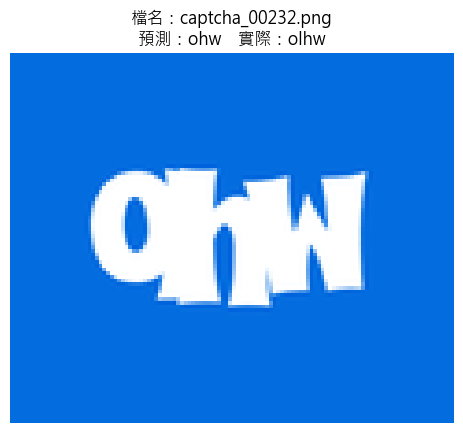

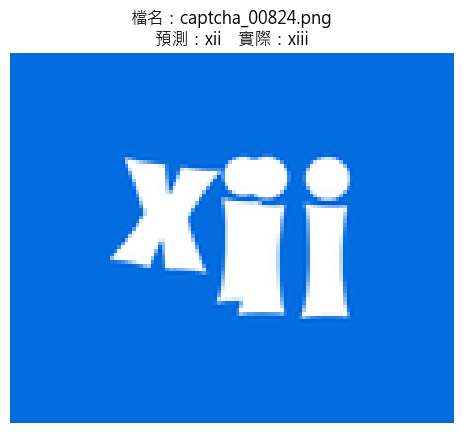

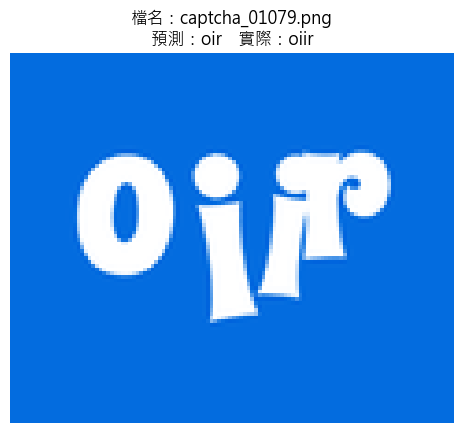

In [36]:
import matplotlib.pyplot as plt

# 設定 matplotlib 使用支援中文的字型
plt.rcParams["font.family"] = "Microsoft JhengHei"
plt.rcParams["axes.unicode_minus"] = False

# 顯示錯誤圖片
print(f"準確率：{accuracy:.3%} ({correct} / {len(filename_to_label)})")
print("\n錯誤圖片顯示：")
for row in wrong_df.head(3).itertuples():
    img_path = IMG_DIR / row.filename
    image = Image.open(img_path).convert("RGB")
    plt.imshow(image)
    plt.title(f"檔名：{row.filename}\n預測：{row.predicted}    實際：{row.true_label}")
    plt.axis("off")
    plt.show()

In [37]:
OUTPUT_DIR = BASE_DIR / "output"
OUTPUT_DIR.mkdir(exist_ok=True)

# 將錯誤資料輸出成 CSV
wrong_csv_path = OUTPUT_DIR / "wrong_predictions.csv"
wrong_df.to_csv(wrong_csv_path, index=False, encoding="utf-8")


print(f"錯誤資料已匯出: {wrong_csv_path}")

錯誤資料已匯出: C:\Code\Project\ticket-sniper-bot\tixcraft\ocr\output\wrong_predictions.csv


In [ ]:
# 將所有資料輸出成 CSV
all_df = pd.DataFrame(predictions, columns=["filename", "true_label", "predicted"])
all_df.to_csv(BASE_DIR / "output" / "all_predictions.csv", index=False)